In [1]:
import sys
sys.path.append('tsp')
import os
from os import path, listdir
from tsp import benchmarks,metrics,tspplot
from tsp.tspobject import TSPObject
import numpy as np
import random


benchmark_path = r'benchmarks'

In [2]:
def random_tour(tsp_data):
    #names = tsp_data['names'] sorted([n[0] for n in tsp_data['nodes']])        
    return list(np.random.permutation(tsp_data.V)) #[names[0]] + list(np.random.permutation(names[1:]))

#Utilizando la segmentacion del programa TSP_Norvig lo implemente para que funcione con PSO
def all_segments(N):
    return [(start, start + length)
            for length in range(N, 2-1, -1)
            for start in range(N - length + 1)]
def reverse_segment_if_better(tsp_data,tour, i, j): 
    # Dado un tour [...A-B...C-D...], Consideramos invertir B...C para tener [...A-C...B-D...]
    A, B, C, D = tour[i-1], tour[i], tour[j-1], tour[j % len(tour)]
    # Los viejos bordes (AB + CD) son mas largos que los nuevos (AC + BD)? Si es asi cambiamos el segmento.
    #Verificamos que sean diferentes los nodos
    if A != B:
        a = tsp_data.M()[str(A)][str(B)]
    else: 
        a = 0
    if C != D:
        b = tsp_data.M()[str(C)][str(D)]
    else:
        b = 0
    if A != C:
        c = tsp_data.M()[str(A)][str(C)]
    else:
        c = 0
    if B != D:
        d = tsp_data.M()[str(B)][str(D)]
    else:
        d = 0
    if (a + b) > (c + d):
        tour[i:j] = reversed(tour[i:j])
        
def alter_tour(tsp_data,tour):
    #tsp_data.metricfunc = metrics.haversine
    original_length = tsp_data.evaluate_tour(tour)
    for (start, end) in all_segments(len(tour)):  
        reverse_segment_if_better(tsp_data,tour, start, end)
    # Si mejora, intentamos seguirlo mejorando, si no termina de alterar el tour
    if tsp_data.evaluate_tour(tour) < original_length:
        return alter_tour(tsp_data,tour)
    return tour

In [3]:
class Particle:
    def __init__(self,tour,pCost=None):
        self.position = tour  #Tour
        self.position_cost = pCost
        self.velocity = 1 #Velocidad de la particula/Probabilidad de Permutación
        self.pos_best = tour  #Mejor posicion
        self.cost_best = pCost #Costo de la mejor ruta
        
    
    def __repr__(self):
        return str(self.position)
    #    return str("Position: ",self.position,"Velocity: ",self.velocity,"Best Pos: ",self.pos_best,"Err Best: ",self.err_best)

    def fitness(self):
        #En caso de que la posicion actual sea mejor que la mejor visitada
        #se cambiara la mejor visitada por la actual
        if self.position_cost < self.cost_best:
            self.pos_best = self.position
            self.cost_best = self.position_cost

    
    def update_velocity(self,pos_best_g,c0,c1,c2):
        #Actualizando velocidad
        r1 = random.random()
        r2 = random.random()
        vel_cognitive = c1*r1*(self.position_cost - self.cost_best)
        vel_social = c2*r2*(self.position_cost - pos_best_g)
        self.velocity = c0*self.velocity+vel_cognitive+vel_social
        return self.velocity
    
    def update_position(self,gbest_pos,V,swarm,k):
        #Actualizar la posicion
        V_average = sum(V)/len(V)
        if V[k] > V_average:
            for a in range(random.randint(0,len(gbest_pos))):
                i = random.randint(0,len(self.position)-1)
                Pj = gbest_pos[i]
                j = int(self.position[self.position.index(Pj)])-1
                Pj = self.position[j]
                Pi = self.position[i]
                self.position[i] = Pj
                self.position[j] = Pi 
        
    def mutation(self,gbest_pos,V,swarm):
        #Mutacion de la particula
        while(True):
            i = random.randint(0,len(self.position)-1)
            j = random.randint(0,len(self.position)-1)
            if i != j:
                break
        
        Pj = self.position[j]
        Pi = self.position[i]
        self.position[i] = Pj
        self.position[j] = Pi 

In [7]:
def Discret_PSO(tsp_data):
    random.seed(69)
    num_dimensions = 2
    mutations = 0
    pM = 0.4
    pr1 = 0.9 #Seguir su propio camino
    pr2 = 0.05 #Seguir su mejor posicion
    pr3 = 0.05 #seguir la mejor global
    N = 100     #Numero de particulas
    V = [0 for v in range(N)]      #Vector de probabilidades de Permutacion(Velocidad)
    Iterations = 1000
    swarm = [Particle(random_tour(tsp_data))  for i in range(N)]
    for p in swarm:
        p.cost_best = tsp_data.evaluate_tour(p.position)
    gbest_pos = swarm[0].position
    gbest_cost = swarm[0].cost_best
    for k in range(Iterations):
        i = 0
        for p in swarm:
            p.position_cost = tsp_data.evaluate_tour(p.position)
            p.fitness()
            if p.position_cost < gbest_cost:
                gbest_pos = p.position
                gbest_cost = p.position_cost
        for p in swarm:
            #Actualizar Velocidad
            V[swarm.index(p)] = p.update_velocity(gbest_cost,pr1,pr2,pr3)
        for p in swarm:
            #Actualizar Posicion/Permutación
            p.update_position(gbest_pos,V,swarm,i)
            if random.random() < pM:
                p.mutation(gbest_pos,V,swarm)
                mutations += 1
            swarm[i] = p
            i+=1
        #Actualizando probabilidades
        pr1 = pr1 * 0.95
        pr2 = pr2 * 1.01
        pr3 = 1 - (pr1 + pr2)
        #Eliminando cruces
        gbest_pos = alter_tour(tsp_data,gbest_pos)
        gbest_cost = tsp_data.evaluate_tour(gbest_pos)
        #tsp_data.metricfunc = metrics.euc_dist
        
        
    print(gbest_pos,"--",gbest_cost)
    print("Mutaciones = ",mutations)
    return gbest_pos

['24', '14', '25', '18', '47', '12', '4', '13', '41', '40', '19', '42', '45', '15', '44', '17', '37', '5', '49', '33', '39', '10', '30', '9', '50', '34', '21', '16', '38', '11', '2', '29', '20', '35', '36', '3', '28', '31', '22', '1', '32', '46', '51', '27', '6', '48', '8', '26', '7', '23', '43'] -- 474.99561223557396
Mutaciones =  40061


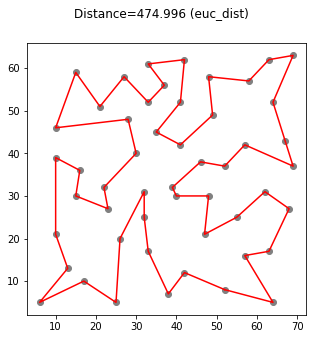

In [8]:
tsp_data = path.join(benchmark_path,'eil51.tsp')
#tsp_data = path.join(benchmark_path,'dj38.tsp')
#tsp_data = path.join(benchmark_path,'berlin52.tsp')
#tsp_data = path.join(benchmark_path,'wi29.tsp')
#tsp_data = path.join(benchmark_path,'burma14.tsp')
#O = TSPObject(tsp_data,metrics.haversine)
O = TSPObject(tsp_data,metrics.euc_dist)
tour = Discret_PSO(O)
tspplot.plot_tsp(O,tour=tour, figsize=(5,5))